The dataset used is a Human Segmentation dataset found on kaggle.

Dataset: https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tapakah68/segmentation-full-body-mads-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/segmentation-full-body-mads-dataset


In [2]:
import os
print("\nContents of path:")
print(os.listdir(path))


Contents of path:
['df.csv', 'segmentation_full_body_mads_dataset_1192_img']


In [3]:
import os
from PIL import Image as PilImage
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
from torchvision.io import read_image
import torchvision.transforms.functional as TF
import numpy as np

In [4]:
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        # Use PIL to open the images
        image = PilImage.open(img_path).convert("RGB")
        mask = PilImage.open(mask_path).convert("L")  # Convert mask to grayscale

        # Apply the transformations if available
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [5]:
class TestDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        image = PilImage.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [6]:
transforms1 = transforms.Compose([
    transforms.Resize((256, 256), interpolation=PilImage.NEAREST),  # Nearest neighbor for masks
    transforms.ToTensor(),
])

In [7]:
dataset = KvasirDataset(
    images_dir = os.path.join(path,"segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images"),
    masks_dir = os.path.join(path,"segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks"),
    transform = transforms1,
    target_transform = transforms1)

In [8]:
total_data = len(dataset)
print(total_data)

1192


In [9]:
# Instantiating dataset for Test Dataset Class

test_dataset = TestDataset(
    images_dir = os.path.join(path,"segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images"),
    transform = transforms1)

In [10]:
test_data = len(test_dataset)
print(test_data)

1192


In [11]:
# Training Validation Split

train_size = int(0.8 * total_data)
val_size = total_data - train_size
print(train_size)
print(val_size)

953
239


In [12]:
import torch.utils.data as data

dataset_train, dataset_val = data.random_split(dataset, [train_size, val_size])

print(len(dataset_train))
print(len(dataset_val))

953
239


In [13]:
# Dataloader

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16, shuffle=True)
dataloader_test= torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [14]:
#Knowing about the data

for images, masks in dataloader_train:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break  # Display the first batch only

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])


In [15]:
#knowing about data
for images in dataloader_test:
    print(f"Image batch shape: {images.shape}")
    break  # Display the first batch only

Image batch shape: torch.Size([16, 3, 256, 256])


In [16]:
# Visualizing Image and their masks

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import seaborn as sns

def display_figures(image_tensor, mask_tensor, idx):
    image_pil = TF.to_pil_image(image_tensor)
    mask_pil = TF.to_pil_image(mask_tensor)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"Image {idx + 1}")
    plt.imshow(image_pil)

    # plt.subplot(1, 4, 2)
    # plt.title(f"Image {idx + 1} Histogram")
    # image_np = np.array(image_pil)
    # plt.hist(image_np.ravel(), bins=256, color='blue')

    plt.subplot(1, 2, 2)
    plt.title(f"Mask {idx + 1}")
    plt.imshow(mask_pil, cmap='gray')

    # plt.subplot(1, 4, 4)
    # plt.title(f"Mask {idx + 1} Histogram")
    # mask_np = np.array(mask_pil)
    # plt.hist(mask_np.ravel(), bins=256, color='blue')

    plt.show()

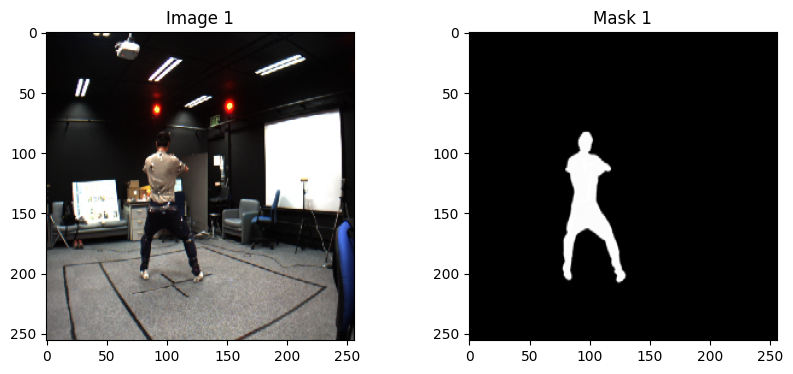

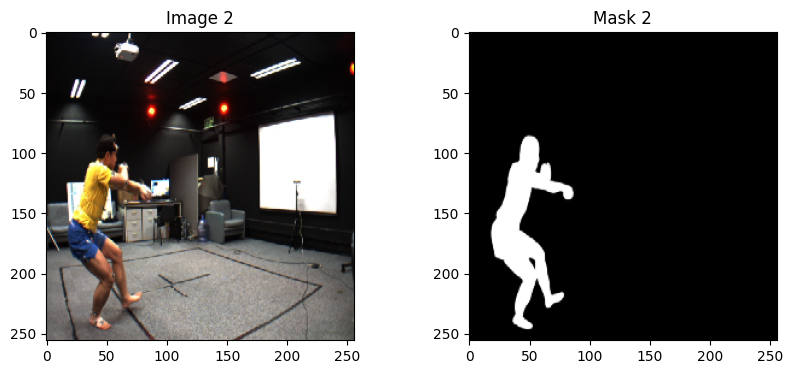

In [17]:
train_images, train_masks = next(iter(dataloader_train))

for i in range(2):
    display_figures(train_images[i], train_masks[i], i)

Using UNET architecture.

In [18]:
## Getting into model part

import torch
import torch.nn as nn
import torchvision


def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True),
  )

  return conv



In [19]:
import torch.nn.functional as F

In [20]:
def center_crop(enc_feature, dec_feature):
    _, _, h, w = dec_feature.size()  # Get the height and width of the decoder feature map
    enc_feature = torchvision.transforms.CenterCrop([h, w])(enc_feature)  # Crop encoder feature
    return enc_feature

Lets create the Model Architecture now.

There are 4 main units:
1. Encoder: Double convolution with increasing channels
2. Downsampling: Maxpooling

3. Upsampling: Transpose Convolution
4. Decoder: (Concatenation and then) Double convolution with decreasing channels

**Note that since `double_conv` and `center_crop` are not static functions inside the class, we call it without using self.**

In [21]:
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet,self).__init__()

    self.enc1 = double_conv(in_channels, 64)
    self.enc2 = double_conv(64,128)
    self.enc3 = double_conv(128,256)
    self.enc4 = double_conv(256,512)
    self.enc5 = double_conv(512,1024)

    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.dec1 = double_conv(1024,512)
    self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.dec2 = double_conv(512,256)
    self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.dec3 = double_conv(256,128)
    self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.dec4 = double_conv(128,64)

    self.out = nn.Conv2d(64, out_channels, kernel_size = 1)


  def forward(self, x):
    x1 = self.enc1(x)
    x2 = self.enc2(self.pool(x1))
    x3 = self.enc3(self.pool(x2))
    x4 = self.enc4(self.pool(x3))
    x5 = self.enc5(self.pool(x4))

    x = self.trans1(x5)
    x = center_crop(x,x4)
    x = torch.cat([x,x4], dim=1)
    x = self.dec1(x)

    x = self.trans2(x)
    x = center_crop(x,x3)
    x = torch.cat([x,x3], dim=1)
    x = self.dec2(x)

    x = self.trans3(x)
    x = center_crop(x,x2)
    x = torch.cat([x,x2], dim=1)
    x = self.dec3(x)

    x = self.trans4(x)
    x = center_crop(x,x1)
    x = torch.cat([x,x1], dim=1)
    x = self.dec4(x)

    x = self.out(x)

    return(x)

In [22]:
#model instantiation

model = UNet(in_channels=3, out_channels=1)

In [23]:
model

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_

In [24]:
!pip install torchviz

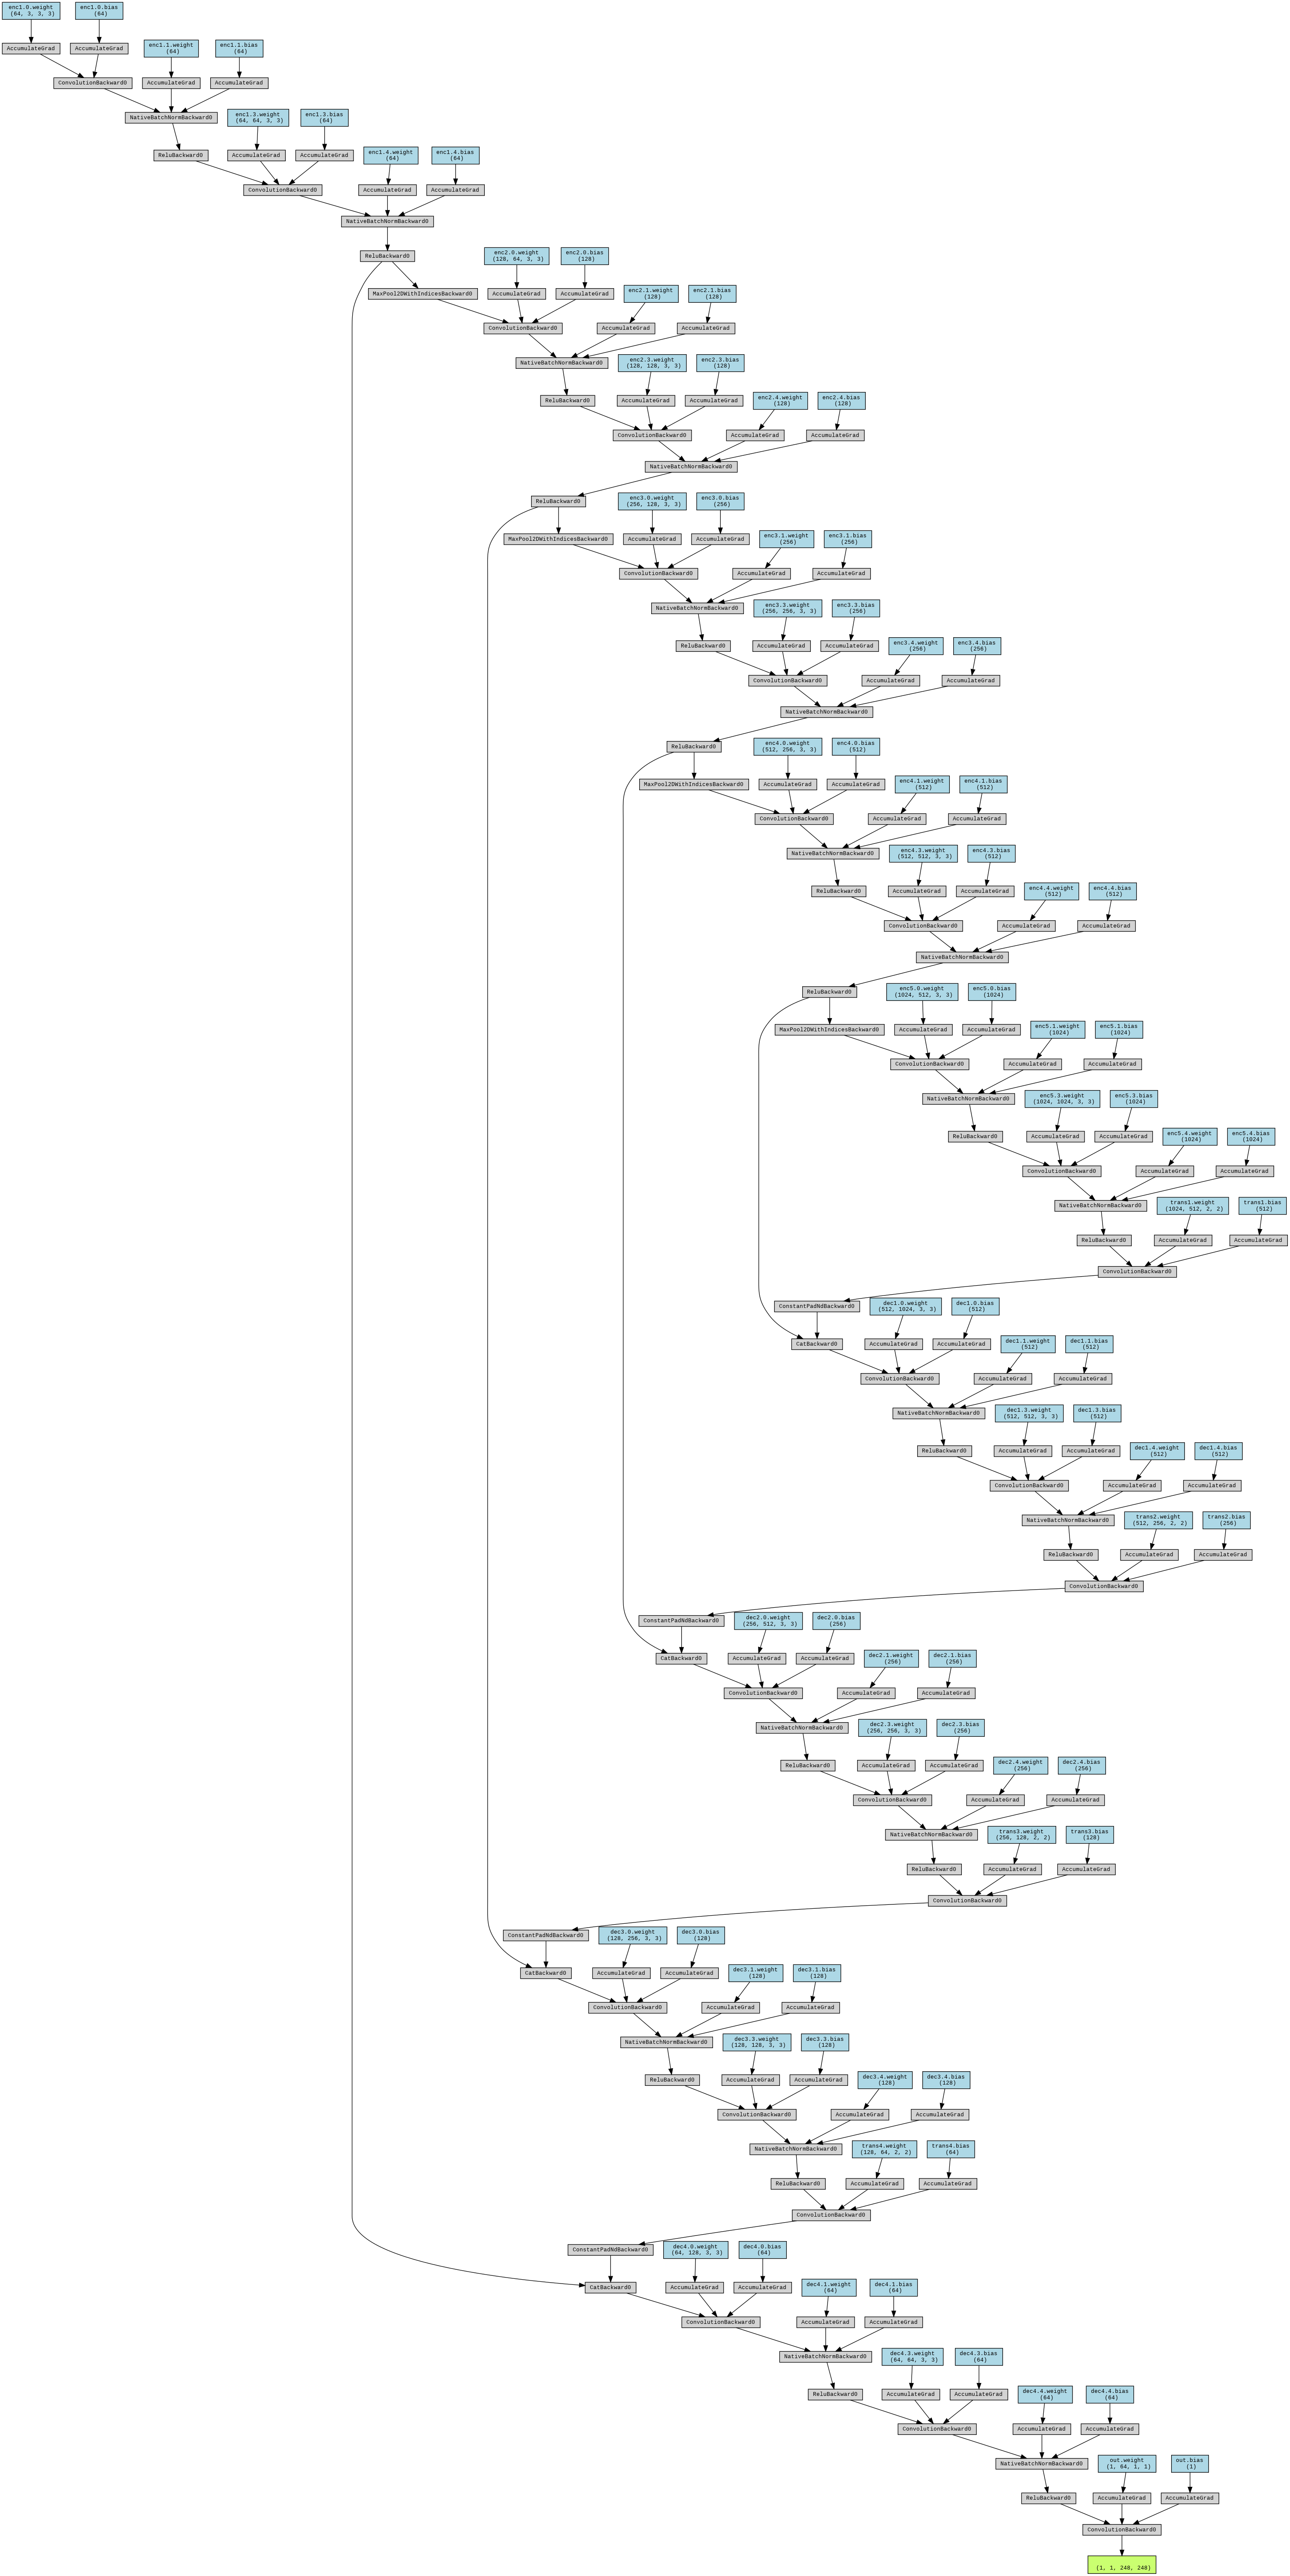

In [25]:
from torchviz import make_dot

sample_input = torch.rand(1,3,256,256)  # b,c,h,w
output = model(sample_input)
dot = make_dot(output, params = dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')

from IPython.display import Image
Image('model_architecture.png')

Training the model

In [26]:
save_path = '/saved_model'
os.makedirs(save_path, exist_ok=True)

In [27]:
class EarlyStoppingAndSave:
    def __init__(self, patience=5, min_delta=0.001, save_path=None, model=None):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = None
        self.best_dice_score = None
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path
        self.model = model

    def check_early_stop(self, val_loss, dice_score, epoch):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.best_dice_score = dice_score
            self.save_model(epoch)
        elif (val_loss > self.best_val_loss - self.min_delta) and (dice_score <= self.best_dice_score + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping activated! Best Val Loss: {self.best_val_loss}, Best Dice Score: {self.best_dice_score}")
                self.early_stop = True
        else:
            self.best_val_loss = min(val_loss, self.best_val_loss)
            self.best_dice_score = max(dice_score, self.best_dice_score)
            self.counter = 0
            self.save_model(epoch)

    def save_model(self, epoch):
        # Save the model if it's the best one so far
        model_save_path = os.path.join(self.save_path, f'best_model_epoch_{epoch+1}.pth')
        torch.save(self.model.state_dict(), model_save_path)
        print(f"Model saved at {model_save_path}")

In [28]:
# Dice Coefficient Calculation
def dice_coefficient(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()  # Binarize predictions
    intersection = (preds * targets).sum()
    dice = (2. * intersection) / (preds.sum() + targets.sum() + 1e-6)
    return dice

Training Loop

In [29]:
!pip install tqdm

In [30]:
from tqdm import tqdm

In [31]:
# Training for one epoch
def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    running_train_loss = 0.0
    num_train_samples = 0.0

    for image, mask in tqdm(train_dataloader, desc="Training", leave=False):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        output = F.interpolate(output, size=mask.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * image.size(0)
        num_train_samples += image.size(0)

    avg_train_loss = running_train_loss / num_train_samples
    return avg_train_loss

In [32]:
# Validation Loop



# Validation for one epoch, returns loss and dice score
def validate_one_epoch(model, val_dataloader, criterion, device):
    model.eval()
    running_val_loss = 0.0
    running_dice_score = 0.0
    num_val_samples = 0.0

    with torch.no_grad():
        for image, mask in tqdm(val_dataloader, desc="Validation", leave=False):
            image, mask = image.to(device), mask.to(device)
            output = model(image)
            output = F.interpolate(output, size=mask.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(output, mask)
            dice_score = dice_coefficient(output, mask)

            running_val_loss += loss.item() * image.size(0)
            running_dice_score += dice_score.item() * image.size(0)
            num_val_samples += image.size(0)

    avg_val_loss = running_val_loss / num_val_samples
    avg_dice_score = running_dice_score / num_val_samples

    return avg_val_loss, avg_dice_score

In [33]:
# Main Loop

# Main training function with early stopping and saving model
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device, patience=5):
    train_losses = []
    val_losses = []
    dice_scores = []
    early_stopping = EarlyStoppingAndSave(patience=patience, save_path=save_path, model=model)

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        train_losses.append(train_loss)

        val_loss, dice_score = validate_one_epoch(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        dice_scores.append(dice_score)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice Score: {dice_score:.4f}")

        # Check for early stopping and save model if the dice score improves
        early_stopping.check_early_stop(val_loss, dice_score, epoch)

        if early_stopping.early_stop:
            print("Training stopped early.")
            break

    return train_losses, val_losses, dice_scores

In [34]:
# Hyper parameters

learning_rate = 0.001
num_epochs = 50    # a large number to facilitate early stopping

criterion = nn.BCEWithLogitsLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
model = model.to(device)

In [36]:
import torch.optim as optim

In [37]:
train_losses, val_losses, dice_scores = train_model(
    model=model,
    train_dataloader=dataloader_train,
    val_dataloader=dataloader_val,
    optimizer=optim.Adam(model.parameters(), lr=learning_rate),
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=10  # Patience for early stopping
)

Training: 100%|██████████| 60/60 [00:59<00:00,  1.20it/s]
                                                         
Epochs:   2%|▏         | 1/50 [01:07<55:23, 67.83s/it]

Epoch [1/50], Train Loss: 0.1980, Val Loss: 0.1218, Dice Score: 0.3663
Model saved at /saved_model/best_model_epoch_1.pth



Training: 100%|██████████| 60/60 [00:53<00:00,  1.30it/s]
                                                         
Epochs:   4%|▍         | 2/50 [02:08<50:46, 63.47s/it]

Epoch [2/50], Train Loss: 0.0662, Val Loss: 0.0565, Dice Score: 0.8274
Model saved at /saved_model/best_model_epoch_2.pth



Training: 100%|██████████| 60/60 [00:53<00:00,  1.25it/s]
                                                         
Epochs:   6%|▌         | 3/50 [03:08<48:31, 61.95s/it]

Epoch [3/50], Train Loss: 0.0394, Val Loss: 0.0405, Dice Score: 0.8115
Model saved at /saved_model/best_model_epoch_3.pth



Training: 100%|██████████| 60/60 [00:53<00:00,  1.19it/s]
                                                         
Epochs:   8%|▊         | 4/50 [04:08<47:05, 61.42s/it]

Epoch [4/50], Train Loss: 0.0285, Val Loss: 0.0261, Dice Score: 0.9018
Model saved at /saved_model/best_model_epoch_4.pth



Training: 100%|██████████| 60/60 [00:54<00:00,  1.25it/s]
                                                         
Epochs:  10%|█         | 5/50 [05:10<46:03, 61.41s/it]

Epoch [5/50], Train Loss: 0.0236, Val Loss: 0.0225, Dice Score: 0.9088
Model saved at /saved_model/best_model_epoch_5.pth



Training: 100%|██████████| 60/60 [00:55<00:00,  1.25it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]
                                                           

Epoch [6/50], Train Loss: 0.0203, Val Loss: 0.0188, Dice Score: 0.9285


Epochs:  12%|█▏        | 6/50 [06:13<45:21, 61.85s/it]

Model saved at /saved_model/best_model_epoch_6.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.11it/s]
                                                         
Epochs:  14%|█▍        | 7/50 [07:16<44:42, 62.37s/it]

Epoch [7/50], Train Loss: 0.0173, Val Loss: 0.0190, Dice Score: 0.9295
Model saved at /saved_model/best_model_epoch_7.pth



Training: 100%|██████████| 60/60 [00:55<00:00,  1.16it/s]
                                                         
Epochs:  16%|█▌        | 8/50 [08:19<43:42, 62.45s/it]

Epoch [8/50], Train Loss: 0.0152, Val Loss: 0.0155, Dice Score: 0.9273
Model saved at /saved_model/best_model_epoch_8.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]
                                                           

Epoch [9/50], Train Loss: 0.0139, Val Loss: 0.0146, Dice Score: 0.9398


Epochs:  18%|█▊        | 9/50 [09:22<42:46, 62.60s/it]

Model saved at /saved_model/best_model_epoch_9.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.16it/s]
                                                         
Epochs:  20%|██        | 10/50 [10:25<41:53, 62.83s/it]

Epoch [10/50], Train Loss: 0.0131, Val Loss: 0.0151, Dice Score: 0.9307



Training: 100%|██████████| 60/60 [00:56<00:00,  1.21it/s]
                                                         
Epochs:  22%|██▏       | 11/50 [11:28<40:56, 62.98s/it]

Epoch [11/50], Train Loss: 0.0124, Val Loss: 0.0127, Dice Score: 0.9417
Model saved at /saved_model/best_model_epoch_11.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.16it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]
                                                           

Epoch [12/50], Train Loss: 0.0118, Val Loss: 0.0125, Dice Score: 0.9461


Epochs:  24%|██▍       | 12/50 [12:31<39:53, 62.99s/it]

Model saved at /saved_model/best_model_epoch_12.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.14it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]
                                                           

Epoch [13/50], Train Loss: 0.0108, Val Loss: 0.0114, Dice Score: 0.9508


Epochs:  26%|██▌       | 13/50 [13:35<38:57, 63.18s/it]

Model saved at /saved_model/best_model_epoch_13.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.20it/s]
                                                         
Epochs:  28%|██▊       | 14/50 [14:38<37:55, 63.21s/it]

Epoch [14/50], Train Loss: 0.0104, Val Loss: 0.0116, Dice Score: 0.9495



Training: 100%|██████████| 60/60 [00:56<00:00,  1.20it/s]
                                                         
Epochs:  30%|███       | 15/50 [15:41<36:53, 63.24s/it]

Epoch [15/50], Train Loss: 0.0100, Val Loss: 0.0106, Dice Score: 0.9510



Training: 100%|██████████| 60/60 [00:56<00:00,  1.14it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]
                                                           

Epoch [16/50], Train Loss: 0.0097, Val Loss: 0.0103, Dice Score: 0.9516


Epochs:  32%|███▏      | 16/50 [16:45<35:52, 63.31s/it]

Model saved at /saved_model/best_model_epoch_16.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Epochs:  34%|███▍      | 17/50 [17:48<34:46, 63.22s/it]

Epoch [17/50], Train Loss: 0.0123, Val Loss: 0.0317, Dice Score: 0.8409



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Epochs:  36%|███▌      | 18/50 [18:51<33:45, 63.29s/it]

Epoch [18/50], Train Loss: 0.0141, Val Loss: 0.0124, Dice Score: 0.9384



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Epochs:  38%|███▊      | 19/50 [19:55<32:43, 63.32s/it]

Epoch [19/50], Train Loss: 0.0104, Val Loss: 0.0113, Dice Score: 0.9446



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Epochs:  40%|████      | 20/50 [20:58<31:37, 63.24s/it]

Epoch [20/50], Train Loss: 0.0097, Val Loss: 0.0118, Dice Score: 0.9385



Training: 100%|██████████| 60/60 [00:56<00:00,  1.16it/s]
                                                         
Epochs:  42%|████▏     | 21/50 [22:01<30:31, 63.17s/it]

Epoch [21/50], Train Loss: 0.0093, Val Loss: 0.0101, Dice Score: 0.9522



Training: 100%|██████████| 60/60 [00:56<00:00,  1.16it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]
                                                           

Epoch [22/50], Train Loss: 0.0089, Val Loss: 0.0098, Dice Score: 0.9538


Epochs:  44%|████▍     | 22/50 [23:04<29:32, 63.30s/it]

Model saved at /saved_model/best_model_epoch_22.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.20it/s]
                                                         
Epochs:  46%|████▌     | 23/50 [24:08<28:30, 63.34s/it]

Epoch [23/50], Train Loss: 0.0087, Val Loss: 0.0094, Dice Score: 0.9548



Training: 100%|██████████| 60/60 [00:56<00:00,  1.20it/s]
                                                         
Epochs:  48%|████▊     | 24/50 [25:11<27:26, 63.31s/it]

Epoch [24/50], Train Loss: 0.0084, Val Loss: 0.0094, Dice Score: 0.9541



Training: 100%|██████████| 60/60 [00:56<00:00,  1.15it/s]
                                                         
Epochs:  50%|█████     | 25/50 [26:14<26:23, 63.32s/it]

Epoch [25/50], Train Loss: 0.0082, Val Loss: 0.0094, Dice Score: 0.9519



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Epochs:  52%|█████▏    | 26/50 [27:18<25:19, 63.33s/it]

Epoch [26/50], Train Loss: 0.0082, Val Loss: 0.0091, Dice Score: 0.9537



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]
                                                           

Epoch [27/50], Train Loss: 0.0079, Val Loss: 0.0090, Dice Score: 0.9573


Epochs:  54%|█████▍    | 27/50 [28:22<24:19, 63.45s/it]

Model saved at /saved_model/best_model_epoch_27.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Epochs:  56%|█████▌    | 28/50 [29:25<23:17, 63.51s/it]

Epoch [28/50], Train Loss: 0.0078, Val Loss: 0.0092, Dice Score: 0.9546



Training: 100%|██████████| 60/60 [00:56<00:00,  1.16it/s]
                                                         
Epochs:  58%|█████▊    | 29/50 [30:28<22:12, 63.45s/it]

Epoch [29/50], Train Loss: 0.0079, Val Loss: 0.0088, Dice Score: 0.9566



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Epochs:  60%|██████    | 30/50 [31:32<21:08, 63.42s/it]

Epoch [30/50], Train Loss: 0.0078, Val Loss: 0.0089, Dice Score: 0.9558



Training: 100%|██████████| 60/60 [00:57<00:00,  1.18it/s]
                                                         
Epochs:  62%|██████▏   | 31/50 [32:36<20:08, 63.59s/it]

Epoch [31/50], Train Loss: 0.0076, Val Loss: 0.0087, Dice Score: 0.9581



Training: 100%|██████████| 60/60 [00:56<00:00,  1.20it/s]
                                                         
Epochs:  64%|██████▍   | 32/50 [33:39<19:03, 63.55s/it]

Epoch [32/50], Train Loss: 0.0074, Val Loss: 0.0091, Dice Score: 0.9553



Training: 100%|██████████| 60/60 [00:56<00:00,  1.17it/s]
                                                         
Epochs:  66%|██████▌   | 33/50 [34:43<17:59, 63.49s/it]

Epoch [33/50], Train Loss: 0.0074, Val Loss: 0.0090, Dice Score: 0.9564



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Validation: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]
                                                           

Epoch [34/50], Train Loss: 0.0072, Val Loss: 0.0088, Dice Score: 0.9588


Epochs:  68%|██████▊   | 34/50 [35:46<16:56, 63.55s/it]

Model saved at /saved_model/best_model_epoch_34.pth



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Epochs:  70%|███████   | 35/50 [36:50<15:54, 63.61s/it]

Epoch [35/50], Train Loss: 0.0072, Val Loss: 0.0090, Dice Score: 0.9568



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Epochs:  72%|███████▏  | 36/50 [37:54<14:49, 63.57s/it]

Epoch [36/50], Train Loss: 0.0071, Val Loss: 0.0087, Dice Score: 0.9581



Training: 100%|██████████| 60/60 [00:57<00:00,  1.17it/s]
                                                         
Epochs:  74%|███████▍  | 37/50 [38:57<13:47, 63.65s/it]

Epoch [37/50], Train Loss: 0.0070, Val Loss: 0.0090, Dice Score: 0.9571



Training: 100%|██████████| 60/60 [00:56<00:00,  1.17it/s]
                                                         
Epochs:  76%|███████▌  | 38/50 [40:01<12:42, 63.55s/it]

Epoch [38/50], Train Loss: 0.0069, Val Loss: 0.0087, Dice Score: 0.9583



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Epochs:  78%|███████▊  | 39/50 [41:04<11:39, 63.57s/it]

Epoch [39/50], Train Loss: 0.0068, Val Loss: 0.0088, Dice Score: 0.9588



Training: 100%|██████████| 60/60 [00:56<00:00,  1.18it/s]
                                                         
Epochs:  80%|████████  | 40/50 [42:08<10:36, 63.62s/it]

Epoch [40/50], Train Loss: 0.0067, Val Loss: 0.0089, Dice Score: 0.9592



Training: 100%|██████████| 60/60 [00:56<00:00,  1.17it/s]
                                                         
Epochs:  82%|████████▏ | 41/50 [43:12<09:32, 63.60s/it]

Epoch [41/50], Train Loss: 0.0066, Val Loss: 0.0092, Dice Score: 0.9548



Training: 100%|██████████| 60/60 [00:56<00:00,  1.17it/s]
                                                         
Epochs:  84%|████████▍ | 42/50 [44:15<08:28, 63.56s/it]

Epoch [42/50], Train Loss: 0.0067, Val Loss: 0.0087, Dice Score: 0.9596



Training: 100%|██████████| 60/60 [00:57<00:00,  1.19it/s]
                                                         
Epochs:  86%|████████▌ | 43/50 [45:19<07:25, 63.68s/it]

Epoch [43/50], Train Loss: 0.0066, Val Loss: 0.0089, Dice Score: 0.9576



Training: 100%|██████████| 60/60 [00:56<00:00,  1.19it/s]
                                                         
Epochs:  86%|████████▌ | 43/50 [46:23<07:33, 64.72s/it]

Epoch [44/50], Train Loss: 0.0065, Val Loss: 0.0087, Dice Score: 0.9594
Early stopping activated! Best Val Loss: 0.008818911497625348, Best Dice Score: 0.9587744441990075
Training stopped early.


In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = [points[0]]  # Initialize with first point
    for point in points[1:]:
        smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
    return smoothed_points

In [ ]:
def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    smoothed_val_losses = smooth_curve(val_losses)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, smoothed_val_losses, 'r', label='Validation Loss (smoothed)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, max(train_losses + val_losses) * 1.1)
    plt.show()

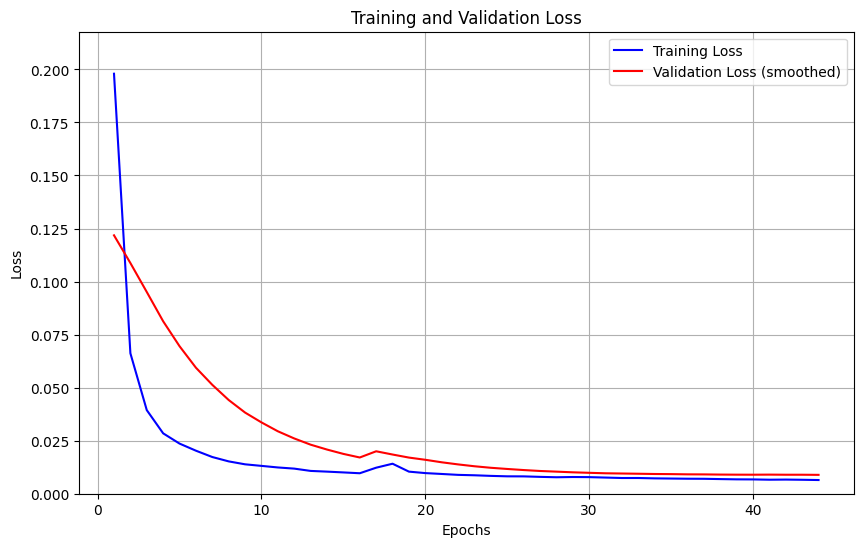

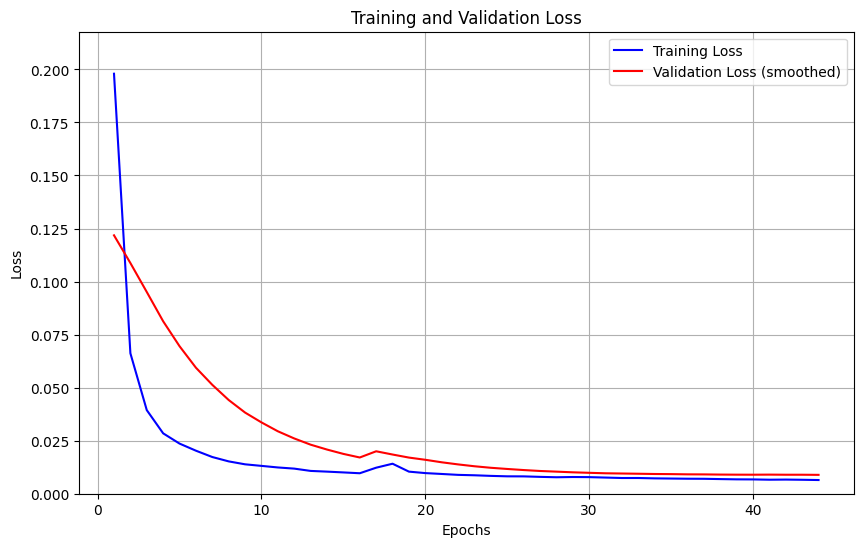

In [40]:
plot_loss_curve(train_losses, val_losses)

In [41]:
model = UNet(in_channels=3, out_channels=1)

In [44]:
model.load_state_dict(torch.load('/saved_model/best_model_epoch_34.pth'))

<All keys matched successfully>

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [53]:
model = model.to(device)
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_

In [54]:
def dice_score(preds, targets):
    smooth=1e-6
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

In [55]:
def display_image_gt_pred(image_tensor, ground_truth_tensor, predictions_tensor, dice_score, idx, title):
    image_pil = TF.to_pil_image(image_tensor)
    ground_truth_pil = TF.to_pil_image(ground_truth_tensor)
    predictions_pil = TF.to_pil_image(predictions_tensor)

    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.title(f"Image {idx + 1}")
    plt.imshow(image_pil)

    # Display ground truth mask
    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth {idx + 1}")
    plt.imshow(ground_truth_pil, cmap='gray')

    # Display prediction mask with Dice score
    plt.subplot(1, 3, 3)
    plt.title(f"Prediction {idx + 1} (Dice: {dice_score:.4f})")
    plt.imshow(predictions_pil, cmap='gray')

    plt.suptitle(title)


To sort and extract the best and worst instances, lets create a list called `results`. It is not just a simple list, but contains dictionaries. Each dictionary contains the following key value pairs:
1. image: original image tensor of shape [c,h,w]
2. ground truth: tensor of gt mask of shape [h,w]
3. prediction: tensor of mask tensor (after applying sigmoid and thresholding, to creata a binary mask)
4. dice score: a float value of dice score between predicted mask and ground truth mask.

In [56]:
####

# Initialize list to store results
results = []

# Perform inference and store images, ground truth, predictions, and dice scores
with torch.no_grad():
    for idx, (images, ground_truths) in enumerate(dataloader_val):
        images = images.to(device)
        ground_truths = ground_truths.to(device)

        # Forward pass through the model
        outputs = model(images)
        outputs = F.interpolate(outputs, size=ground_truths.shape[2:], mode='bilinear', align_corners=False)

        # Apply sigmoid to get probabilities and binarize predictions (threshold at 0.5)
        predictions = torch.sigmoid(outputs)
        predictions = (predictions > 0.5).float()

        # Compute dice score for each sample in the batch
        for i in range(len(images)):
            current_dice = dice_score(predictions[i], ground_truths[i])

            # Store image, ground truth, prediction, and dice score in the results list
            results.append({
                'image': images[i].cpu(),
                'ground_truth': ground_truths[i].cpu(),
                'prediction': predictions[i].cpu(),
                'dice_score': current_dice
            })

In [57]:
results = sorted(results, key=lambda x: x['dice_score'])


Top 5 Best Predictions:


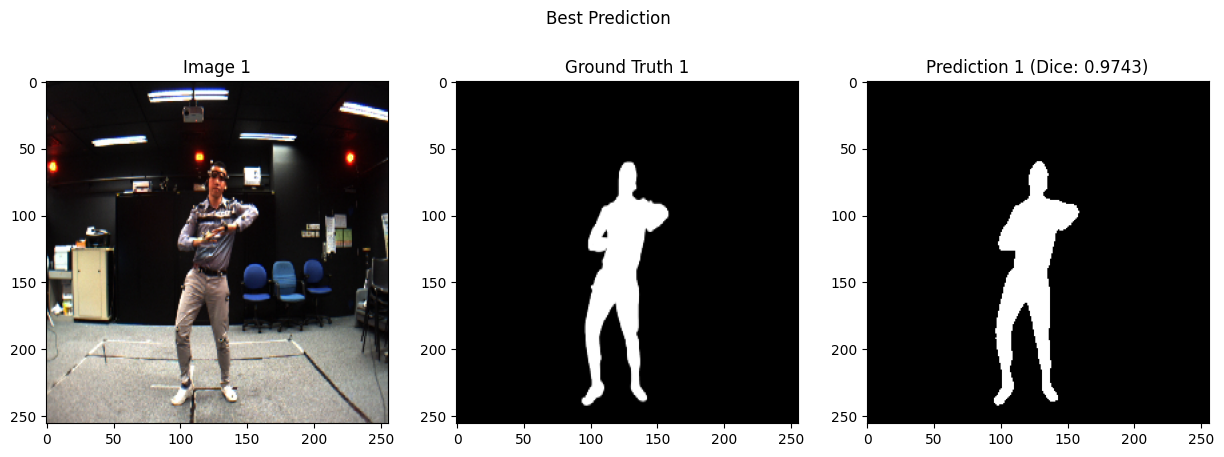

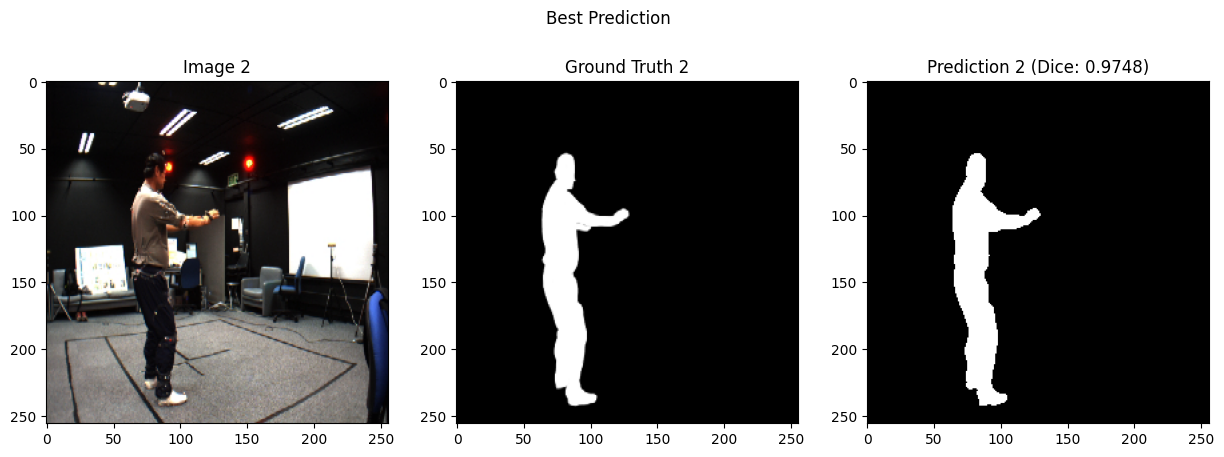

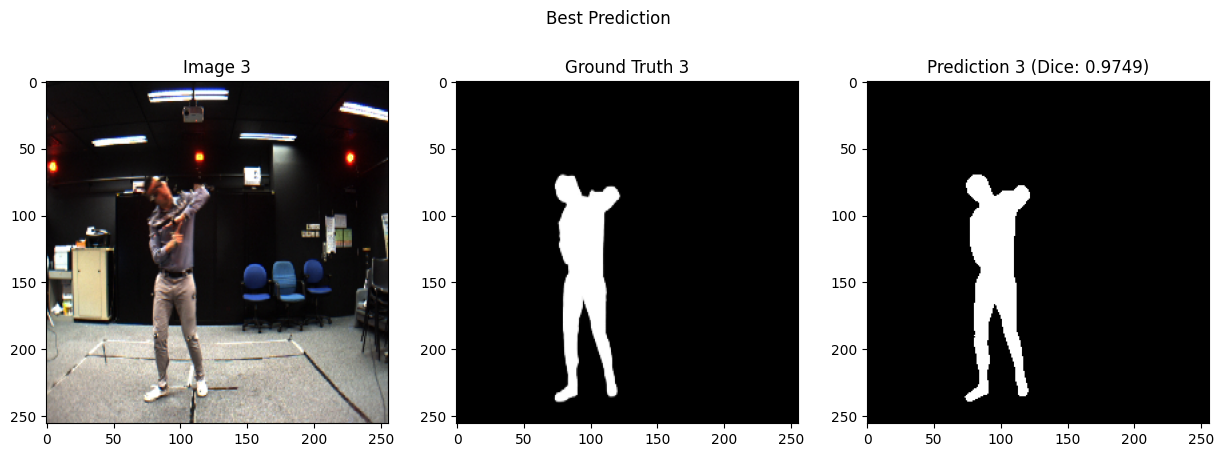

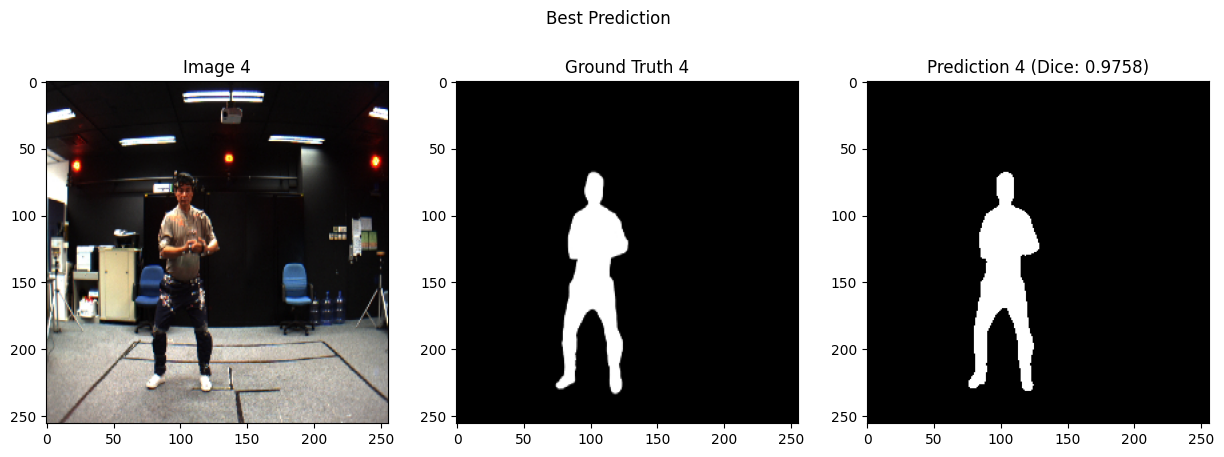

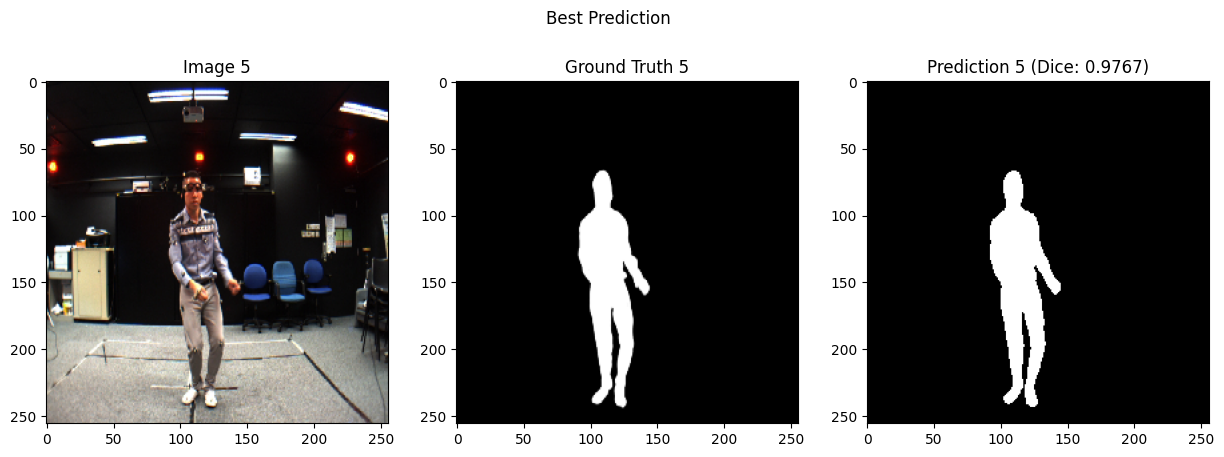

In [58]:
print("\nTop 5 Best Predictions:")
for idx, result in enumerate(results[-5:]):
    display_image_gt_pred(result['image'], result['ground_truth'], result['prediction'],
                          result['dice_score'], idx, title='Best Prediction')

Top 5 Worst Predictions:


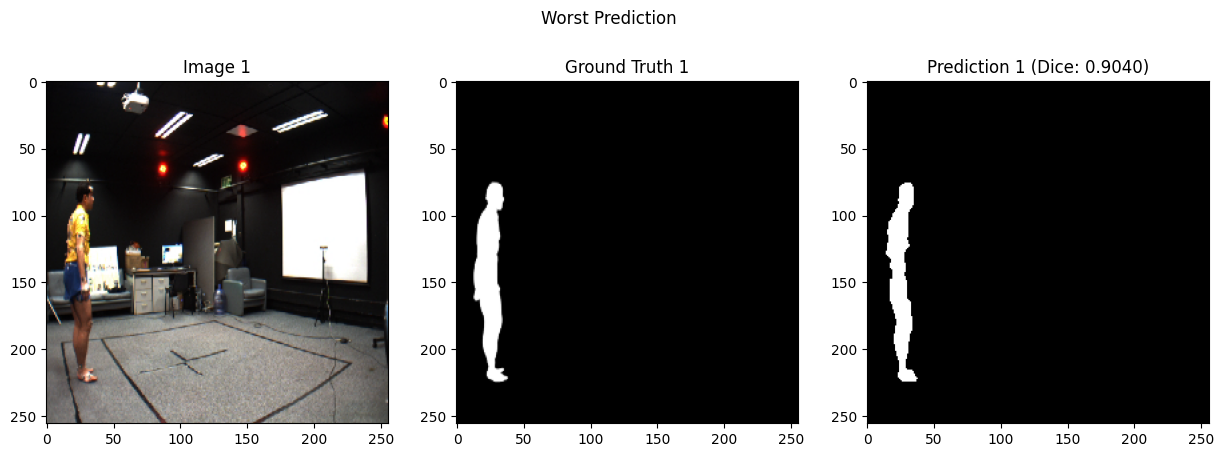

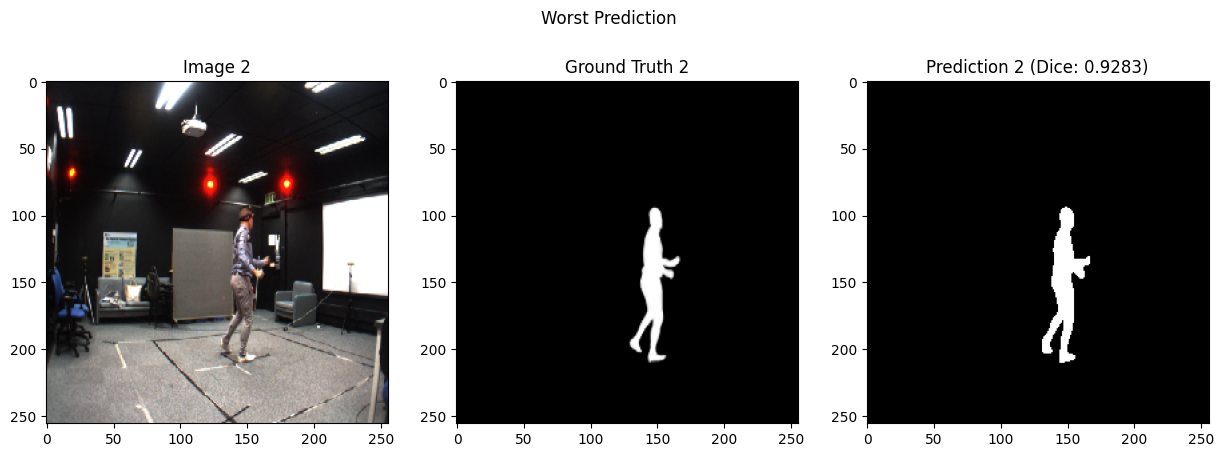

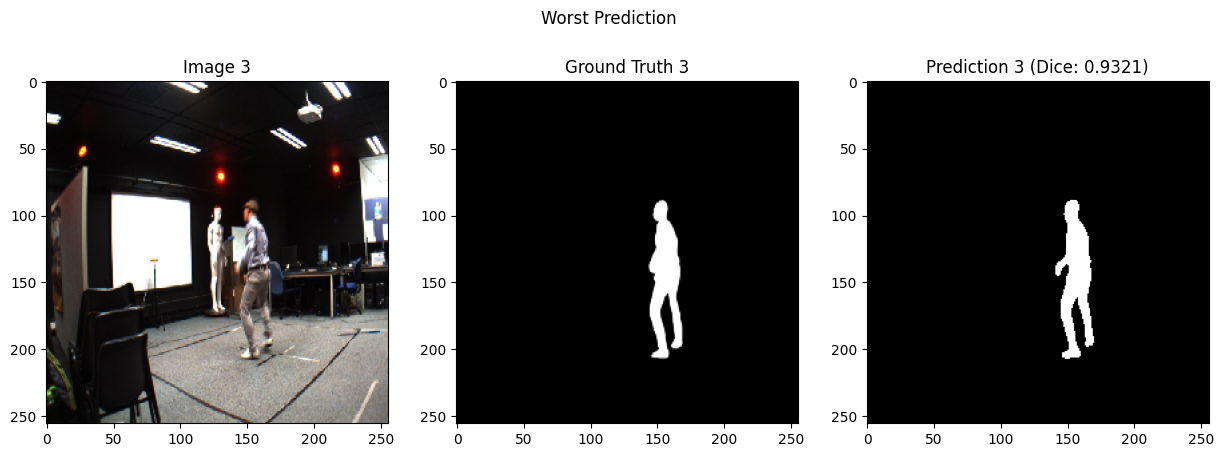

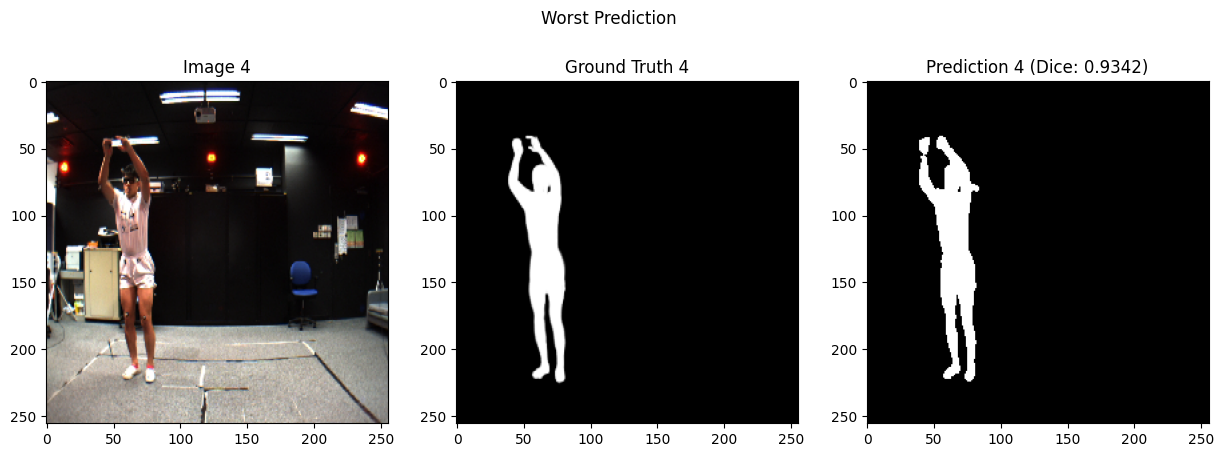

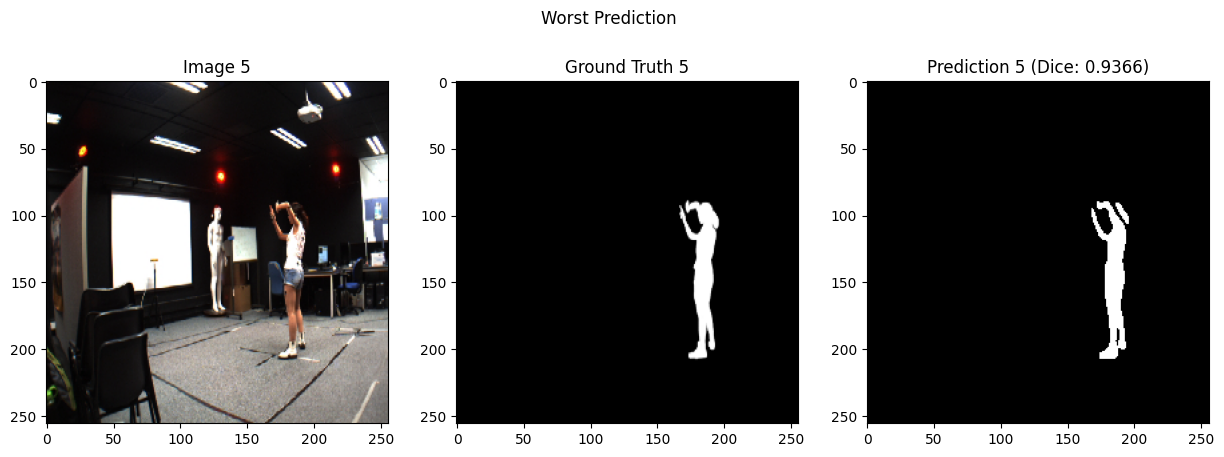

In [59]:
#####

print("Top 5 Worst Predictions:")
for idx, result in enumerate(results[:5]):
    display_image_gt_pred(result['image'], result['ground_truth'], result['prediction'],
                          result['dice_score'], idx, title='Worst Prediction')


Test Dataset

In [ ]:
model = UNet(in_channels=3, out_channels=1)

In [45]:
model.load_state_dict(torch.load('/saved_model/best_model_epoch_34.pth'))

<All keys matched successfully>

In [46]:
model = model.to(device)
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_

In [47]:
with torch.no_grad():
    for idx, images in enumerate(dataloader_test):
        test_images = images.to(device)

        test_outputs = model(test_images)

        # Apply sigmoid to get probabilities
        test_predictions = torch.sigmoid(test_outputs)

        # Binarize predictions (threshold at 0.5)
        test_predictions = (test_predictions > 0.5).float()

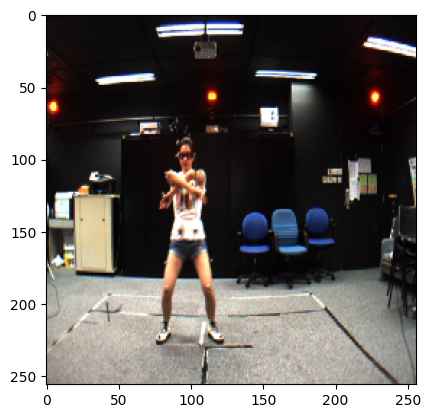

In [48]:
plt.imshow(TF.to_pil_image(test_images[3]))

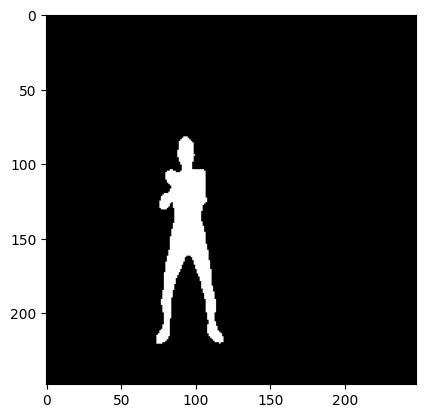

In [49]:
plt.imshow(TF.to_pil_image(test_predictions[3]), cmap = 'gray')